In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"bananapple","key":"75eb3c0872d58bbdaf9df31824376852"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gmlmrinalini/manwomandetection

manwomandetection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#압축풀기
import zipfile

local_zip = '/content/manwomandetection.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

# directory 지정하기

In [6]:
#기본 경로지정

base_dir='/content/dataset'

train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
val_dir=os.path.join(base_dir,'result')

In [7]:
#훈련에 사용되는 이미지 경로
train_man_dir=os.path.join(train_dir,'man')
train_woman_dir=os.path.join(train_dir,'woman')

#validation 이미지 경로
val_man_dir=os.path.join(val_dir,'man')
val_woman_dir=os.path.join(val_dir,'woman')

#test 이미지 경로
test_man_dir=os.path.join(test_dir,'man')
test_woman_dir=os.path.join(test_dir,'woman')

In [8]:
#이미지 파일들을 리스트에 담기
#train
train_man_fnames=os.listdir(train_man_dir)
train_woman_fnames=os.listdir(train_woman_dir)

print(train_woman_fnames[:5])

#validation
val_man_fnames=os.listdir(val_man_dir)
val_woman_fnames=os.listdir(val_woman_dir)

print(val_woman_fnames[:5])

#test
test_man_fnames=os.listdir(test_man_dir)
test_woman_fnames=os.listdir(test_woman_dir)

print(test_woman_fnames[:5])



['face_1244.jpg', 'face_1055.jpg', 'face_571.jpg', 'face_548.jpg', 'face_1151.jpg']
['face_280.jpg', 'face_273.jpg', 'face_278.jpg', 'face_345.jpg', 'face_260.jpg']
['face_175.jpg', 'face_73.jpg', 'face_161.jpg', 'face_163.jpg', 'face_64.jpg']


In [9]:
#각 리스트에 파일이 몇개 담겨있는지 확인하기
print('train man {}'.format(len(train_man_fnames)))
print('train woman {}'.format(len(train_woman_fnames)))
#validation
print('val man {}'.format(len(val_man_fnames)))
print('val woman {}'.format(len(val_woman_fnames)))
#test
print('train man {}'.format(len(test_man_fnames)))
print('train woman {}'.format(len(test_woman_fnames)))

train man 821
train woman 794
val man 176
val woman 170
train man 176
train woman 170


# 데이터셋/전처리

In [10]:
bacth=30
img_height=150
img_width=150

In [11]:
#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                )

val_datagen=ImageDataGenerator(rescale=1./255 )

test_datagen=ImageDataGenerator(rescale=1./255,
                                )


batch_list=[20,32,48,64]
train_gen_list=[]
val_gen_list=[]
test_gen_list=[]

for batch_ in batch_list:
  #train
  train_generator=train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_,
                                                    class_mode='binary',
                                                    target_size=(img_height,img_width)
                                                    )
  train_gen_list.append(train_generator)
  #validation
  val_generator=val_datagen.flow_from_directory(val_dir,
                                                batch_size=batch_,
                                                class_mode='binary',
                                                target_size=(img_height,img_width)
                                                )
  val_gen_list.append(val_generator)
  #test
  test_generator=test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_,
                                                  class_mode='binary',
                                                  target_size=(img_height,img_width)
                                                  )
  test_gen_list.append(test_generator)

Found 1615 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 1615 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 1615 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 1615 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 346 images belonging to 2 classes.


# 모델링

In [12]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [13]:
model=keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',input_shape=(img_height,img_width,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

# 학습하기

In [16]:
history=model.fit(train_gen_list[2],
                  epochs=30,
                  validation_data=val_gen_list[2]
                  )
#모델 저장하기
from keras.models import load_model
model.save('man or woman epoch 30, batch=48(캐글).h5')

Epoch 1/30
34/34 [==============================] - 16s 344ms/step - loss: 0.7059 - accuracy: 0.5102 - val_loss: 0.7135 - val_accuracy: 0.5087
Epoch 2/30
34/34 [==============================] - 11s 330ms/step - loss: 0.6993 - accuracy: 0.5269 - val_loss: 0.7260 - val_accuracy: 0.4942
Epoch 3/30
34/34 [==============================] - 11s 330ms/step - loss: 0.6892 - accuracy: 0.5610 - val_loss: 0.6556 - val_accuracy: 0.6532
Epoch 4/30
34/34 [==============================] - 11s 332ms/step - loss: 0.6633 - accuracy: 0.6074 - val_loss: 0.6351 - val_accuracy: 0.6705
Epoch 5/30
34/34 [==============================] - 11s 325ms/step - loss: 0.6733 - accuracy: 0.6297 - val_loss: 0.6483 - val_accuracy: 0.7052
Epoch 6/30
34/34 [==============================] - 11s 331ms/step - loss: 0.6347 - accuracy: 0.6786 - val_loss: 0.5685 - val_accuracy: 0.7254
Epoch 7/30
34/34 [==============================] - 11s 330ms/step - loss: 0.5887 - accuracy: 0.6799 - val_loss: 0.5181 - val_accuracy: 0.8092

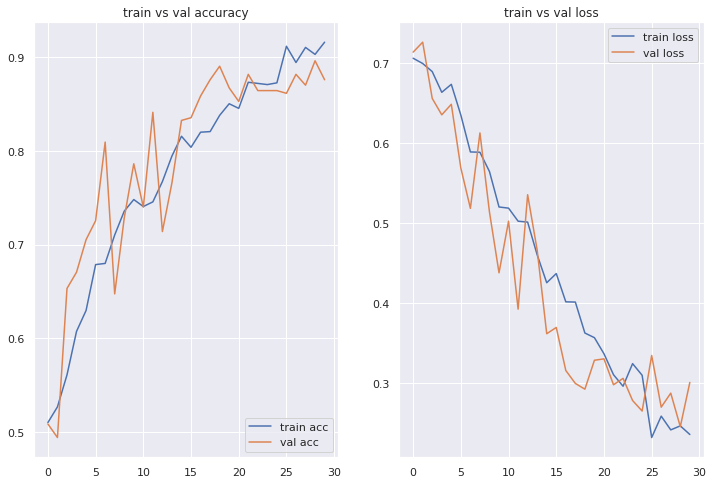

In [17]:
#정확도
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

#오차 확인
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(30)

#accuracy 확인
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train acc')
plt.plot(epochs_range,val_acc,label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

#오차 확인
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend()
plt.title('train vs val loss')

plt.show()

# 이미지 테스트해보기

In [ ]:
ypred=model.predict(test_gen_list[1])
ypred[:10]

array([[6.8279663e-03],
       [9.9861896e-01],
       [1.9742094e-04],
       [8.4177780e-01],
       [6.2827325e-01],
       [4.5385355e-01],
       [9.8875868e-01],
       [9.8777419e-01],
       [9.7985840e-01],
       [7.7870667e-01]], dtype=float32)

In [ ]:
ypred.shape

(346, 1)

In [30]:
#방법2.1
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

def pred_img2(img,i):
  plt.subplot(5,5,i+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  
  plt.axis('off')
  plt.show()

  img_resized=cv2.resize(img,(img_height,img_width))#모델에 들어가는 이미지 크기가 224*224 이기때문에 224*244로 이미지 크기를 조정해줌
  pred=model.predict(img_resized.reshape([1,img_height,img_width,3]))#예측을 할건데 모델.predict(위에서 이미지 크기를 조정한 이미지를 넣고 reshape()로 재배치를 시킨 값을 넣는다.)
  print(pred[0])

  if(pred[0]>0.5):
    print('woman')
  else:
    print('man')

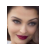

[1.]
woman


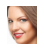

[4.717268e-18]
man


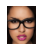

[0.]
man


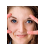

[1.]
woman


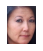

[0.]
man


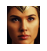

[1.]
woman


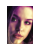

[1.888757e-35]
man


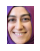

[1.]
woman


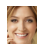

[1.]
woman


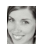

[0.9893225]
woman


In [35]:
img=[]
for name in test_woman_fnames[30:40]:
  img_data=cv2.imread(test_woman_dir+'/'+name)
  img.append(img_data)
for j,data in enumerate(img):
  pred_img2(data,j)

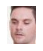

[0.]
man


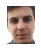

[0.]
man


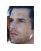

[0.]
man


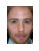

[0.]
man


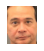

[0.]
man


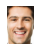

[0.]
man


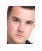

[0.]
man


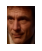

[0.]
man


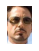

[0.]
man


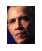

[0.]
man


In [36]:
img=[]
for name in test_man_fnames[30:40]:
  img_data=cv2.imread(test_man_dir+'/'+name)
  img.append(img_data)
for j,data in enumerate(img):
  pred_img2(data,j)

# 테스트 이미지 전처리

In [39]:
#방법2
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2

def pred_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

  img_resized=cv2.resize(img,(img_height,img_width))#모델에 들어가는 이미지 크기가 224*224 이기때문에 224*244로 이미지 크기를 조정해줌
  pred=model.predict(img_resized.reshape([1,img_height,img_width,3]))#예측을 할건데 모델.predict(위에서 이미지 크기를 조정한 이미지를 넣고 reshape()로 재배치를 시킨 값을 넣는다.)
  print(pred[0])

  if(pred[0]>0.5):
    print('woman')
  else:
    print('man')

In [ ]:
import cv2
src=cv2.imread('/content/디카프리오.jfif',cv2.IMREAD_UNCHANGED)

In [ ]:
src.shape

(1280, 938, 3)

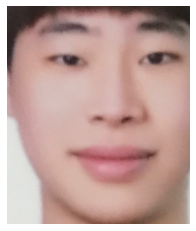

[0.]
man


In [40]:
#내 증명사진
src=cv2.imread('/content/증명사진.jpg',cv2.IMREAD_UNCHANGED)

dst=src[308:796,236:645].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

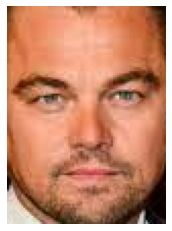

[7.130283e-24]
man


In [41]:
#디카프리오
src=cv2.imread('/content/디카프리오.jfif',cv2.IMREAD_UNCHANGED)

dst=src[48:155,52:130].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

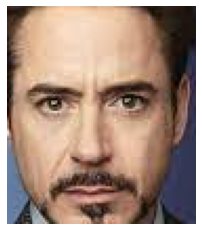

[0.]
man


In [42]:
#로다주 93,40 183,144
src=cv2.imread('/content/로다주.jpg',cv2.IMREAD_UNCHANGED)

dst=src[40:144,93:183].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

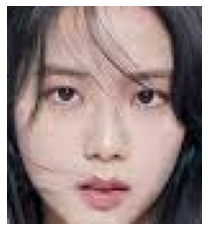

[0.9990988]
woman


In [44]:
#지수 46,37 122,122
src=cv2.imread('/content/지수이미지.jfif',cv2.IMREAD_UNCHANGED)

dst=src[37:122,46:122].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

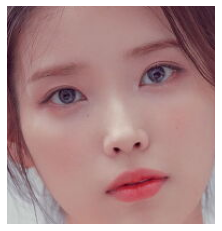

[1.812119e-09]
man


In [53]:
#아이유 139,102 332,304
src=cv2.imread('/content/여자이미지.jpg',cv2.IMREAD_UNCHANGED)

dst=src[102:304,139:332].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

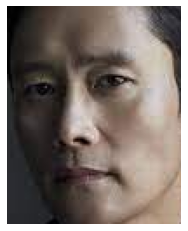

[0.]
man


In [55]:
#이병헌 38,65 138,190
src=cv2.imread('/content/이병헌남자이미지.jfif',cv2.IMREAD_UNCHANGED)

dst=src[65:190,38:138].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)

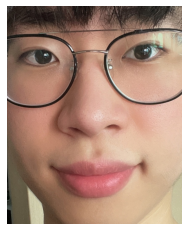

[1.]
woman


In [58]:
#내사진 472,239 1131,1061
src=cv2.imread('/content/내사진.jpg',cv2.IMREAD_UNCHANGED)

dst=src[239:1061,472:1131].copy()

plt.imshow(dst)
plt.axis('off')

pred_img(dst)